In [1]:
pip install polars


   ---------------------------------------- 0.0/35.2 MB ? eta -:--:--
   ------------ --------------------------- 11.0/35.2 MB 64.8 MB/s eta 0:00:01
   -------------------------------- ------- 28.3/35.2 MB 73.6 MB/s eta 0:00:01
   ---------------------------------------- 35.2/35.2 MB 59.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import polars as pl
import os

# ---------- FULL DESCRIPTIVE STATISTICS ----------
def polars_full_describe(file_path):
    df = pl.read_csv(file_path, ignore_errors=True)
    dataset_name = os.path.basename(file_path)
    print(f"\n\n📊 POLARS Dataset: {dataset_name}")

    # ✅ Fix: Manually check for numeric types
    numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64)
    numeric_cols = [col for col in df.columns if isinstance(df.schema[col], numeric_types)]
    cat_cols = [col for col in df.columns if df.schema[col] == pl.Utf8]

    # --- Numeric Summary ---
    if numeric_cols:
        print("\n--- Numeric Summary ---")
        print(df.select(numeric_cols).describe())
    else:
        print("⚠️ No numeric columns found.")

    # --- Categorical Summary ---
    if cat_cols:
        print("\n--- Categorical Summary ---")
        for col in cat_cols:
            try:
                vc = df.group_by(col).agg(pl.count().alias("count")).sort("count", descending=True)
                unique = df.select(pl.col(col).n_unique()).item()
                print(f"\nColumn: {col} | Unique: {unique}")
                print(vc.head(5))
            except Exception as e:
                print(f"⚠️ Could not summarize column {col}: {str(e)}")
    else:
        print("⚠️ No categorical columns found.")

# ---------- GROUPED SUMMARY ----------
def polars_groupby_summary(file_path, group_cols):
    df = pl.read_csv(file_path, ignore_errors=True)
    dataset_name = os.path.basename(file_path)
    print(f"\n\n📊 POLARS Grouped Summary for: {dataset_name} | Grouped by: {group_cols}")

    # ✅ Fix: Same manual type check
    numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64)
    numeric_cols = [col for col in df.columns if isinstance(df.schema[col], numeric_types) and col not in group_cols]

    if not numeric_cols:
        print("⚠️ No numeric columns for aggregation.")
        return

    agg_exprs = []
    for col in numeric_cols:
        agg_exprs.extend([
            pl.col(col).mean().alias(f"{col}_mean"),
            pl.col(col).std().alias(f"{col}_std"),
            pl.col(col).min().alias(f"{col}_min"),
            pl.col(col).max().alias(f"{col}_max"),
            pl.col(col).count().alias(f"{col}_count"),
        ])

    try:
        grouped = df.group_by(group_cols).agg(agg_exprs)

        for row in list(grouped.iter_rows(named=True))[:3]:  # Show only 3 sample groups
            group_info = tuple(row[col] for col in group_cols)
            print(f"\n🔹 Group: {group_info}")
            print(grouped.filter(pl.all_horizontal([pl.col(col) == row[col] for col in group_cols])))
    except Exception as e:
        print(f"⚠️ Grouped summary failed: {str(e)}")


In [26]:
dataset_config = [
    {
        "file": "C:/Users/unnat/OneDrive/Desktop/RA/Task_04_Descriptive_Stats/data/period_03/2024_fb_ads_president_scored_anon.csv",
        "group_cols": ["page_id", "ad_id"]
    },
    {
        "file": "C:/Users/unnat/OneDrive/Desktop/RA/Task_04_Descriptive_Stats/data/period_03/2024_fb_posts_president_scored_anon.csv",
        "group_cols": ["Page Admin Top Country"]
    },
    {
        "file": "C:/Users/unnat/OneDrive/Desktop/RA/Task_04_Descriptive_Stats/data/period_03/2024_tw_posts_president_scored_anon.csv",
        "group_cols": ["source"]
    }
]


In [27]:
for config in dataset_config:
    polars_full_describe(config["file"])
    polars_groupby_summary(config["file"], config["group_cols"])




📊 POLARS Dataset: 2024_fb_ads_president_scored_anon.csv

--- Numeric Summary ---
shape: (9, 32)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ estimated ┆ estimated ┆ estimated ┆ … ┆ womens_is ┆ incivilit ┆ freefair_ ┆ fraud_il │
│ ---       ┆ _audience ┆ _impressi ┆ _spend    ┆   ┆ sue_topic ┆ y_illumin ┆ illuminat ┆ luminati │
│ str       ┆ _size     ┆ ons       ┆ ---       ┆   ┆ _illumina ┆ ating     ┆ ing       ┆ ng       │
│           ┆ ---       ┆ ---       ┆ f64       ┆   ┆ tin…      ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆ f64       ┆           ┆   ┆ ---       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 246745.0  ┆ 246745.0  ┆ 246745.0  ┆ … ┆ 246745.0  ┆ 246745.0  ┆ 246745.0  ┆ 2467

C:\Users\unnat\AppData\Local\Temp\ipykernel_35220\259560432.py:27: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  vc = df.group_by(col).agg(pl.count().alias("count")).sort("count", descending=True)



Column: ad_id | Unique: 246745
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ ad_id                           ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ d5f98cacd1e9260073cd82e6767128… ┆ 1     │
│ 88cffdc75bf804d47b14530547f26c… ┆ 1     │
│ 332844a77e9e8ef5f921d82e84842d… ┆ 1     │
│ fa0d6f0f0a3a349304cd072b61bde8… ┆ 1     │
│ 34cb8ead635134c8c16b4c2cce962c… ┆ 1     │
└─────────────────────────────────┴───────┘

Column: ad_creation_time | Unique: 547
shape: (5, 2)
┌──────────────────┬───────┐
│ ad_creation_time ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ 2024-10-27       ┆ 8619  │
│ 2024-10-28       ┆ 7356  │
│ 2024-10-26       ┆ 6414  │
│ 2024-10-23       ┆ 5021  │
│ 2024-10-25       ┆ 4769  │
└──────────────────┴───────┘

Column: bylines | Unique: 3791
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ bylin

C:\Users\unnat\AppData\Local\Temp\ipykernel_35220\259560432.py:66: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  print(grouped.filter(pl.all_horizontal([pl.col(col) == row[col] for col in group_cols])))



Column: lang | Unique: 12
shape: (5, 2)
┌──────┬───────┐
│ lang ┆ count │
│ ---  ┆ ---   │
│ str  ┆ u32   │
╞══════╪═══════╡
│ en   ┆ 27281 │
│ fr   ┆ 6     │
│ tl   ┆ 4     │
│ es   ┆ 3     │
│ da   ┆ 3     │
└──────┴───────┘

Column: month_year | Unique: 15
shape: (5, 2)
┌────────────┬───────┐
│ month_year ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ 2024-10    ┆ 3586  │
│ 2024-09    ┆ 2856  │
│ 2024-08    ┆ 2647  │
│ 2023-09    ┆ 2336  │
│ 2023-11    ┆ 2334  │
└────────────┴───────┘

Column: illuminating_scored_message | Unique: 27136
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ illuminating_scored_message     ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ 36cb7d55fcf85362ca03f624c2f574… ┆ 21    │
│ 1d2cc25fad0d66a295d4fafdd590d7… ┆ 18    │
│ e85b31153cfcc753f8657eb033c8e8… ┆ 10    │
│ c3adbeed65888d91e375c51dc9cc93… ┆ 7     │
│ de3c280

In [2]:
#Facebook Ads.
# - Average estimated audience size is very high (~556k), but with large variability → some ads reach millions, others just thousands.
# - Mean estimated spend is around $1060, but many ads are much cheaper (~$49) → campaigns run ads at a variety of budget levels.
# - Most ads are flagged as advocacy content; attack and issue types occur but are less frequent.
# - Popular topics include governance, economy, and health — core political themes.
# - Low frequency of scam, fraud, or incivility flags → likely professionally managed and reviewed content.
# - Each (page_id, ad_id) pair mostly appears once → each ad is unique or run once per group.


In [ ]:
#Facebook Post.
# - Mean likes (~2.4k), comments (~900), and shares (~320) indicate solid user engagement.
# - Emotional reactions like Love (~414) and Care are strong → content evokes emotional response.
# - Overperforming Score is often negative (~-2.74) → many posts underperform expected metrics.
# - Advocacy and issue message types dominate; attack and misinformation types are low.
# - Posts grouped by country show the majority are from U.S. pages → confirms domestic election focus.
# - Large variation in engagement by country — some pages consistently outperform others.

In [3]:
#Twitter Posts.
# - Average view count is extremely high (~507k), indicating strong virality potential on Twitter.
# - Likes (~6.9k) and retweets (~1.3k) suggest strong user amplification and content spread.
# - Bookmark count is fairly high (~136) → users actively save political tweets.
# - Advocacy and issue types are again the most common, but attack messaging is more prevalent than on Facebook (~0.31 mean).
# - Tweets grouped by 'source' show heavy use of Media Studio, iPhone, TweetDeck — suggesting official/campaign-managed accounts.
# - Viral tweets often come from Media Studio → content crafted and scheduled by professionals.

Matplotlib is building the font cache; this may take a moment.


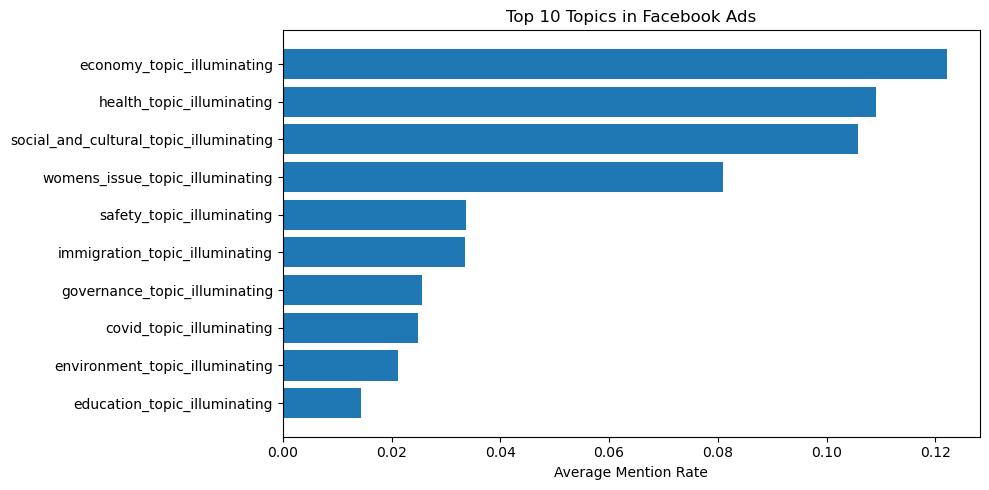

In [4]:
# Facebook Ads Topics Bar Chart (Top 10)
import polars as pl
import matplotlib.pyplot as plt

ads_path = "C:/Users/unnat/OneDrive/Desktop/RA/Task_04_Descriptive_Stats/data/period_03/2024_fb_ads_president_scored_anon.csv"
df_ads = pl.read_csv(ads_path)

# Get topic-related columns
topic_cols = [col for col in df_ads.columns if col.endswith("_topic_illuminating")]

# Compute average for each topic
topic_means = df_ads.select([pl.col(col).mean().alias(col) for col in topic_cols])
topic_df = topic_means.transpose(include_header=True, header_name="topic", column_names=["avg"])
topic_df = topic_df.sort("avg", descending=True).head(10)

# Plotting
topics = topic_df["topic"].to_list()
values = topic_df["avg"].to_list()

plt.figure(figsize=(10, 5))
plt.barh(topics[::-1], values[::-1])
plt.xlabel("Average Mention Rate")
plt.title("Top 10 Topics in Facebook Ads")
plt.tight_layout()
plt.show()


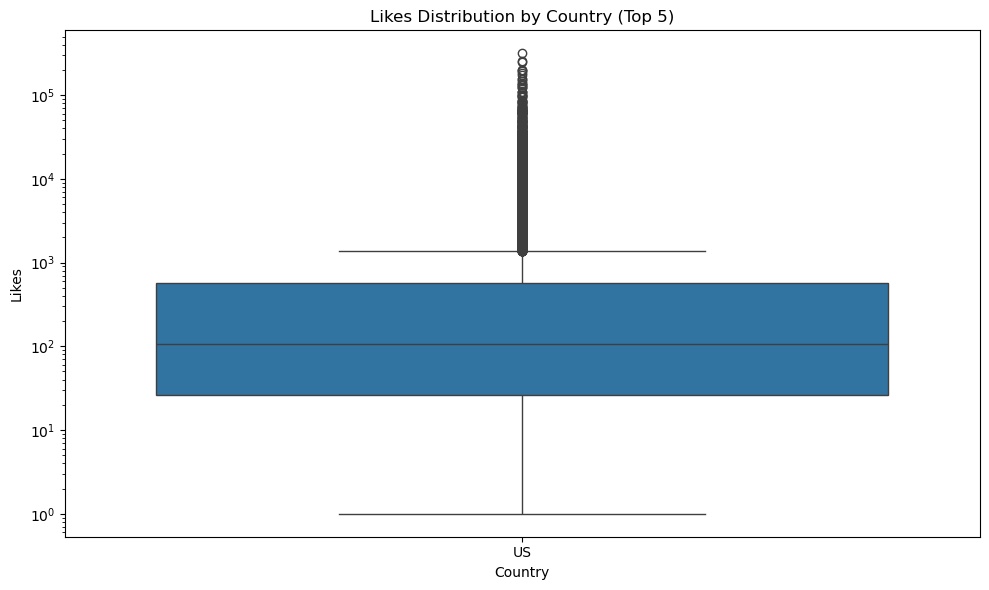

In [5]:
# Facebook Posts Boxplot – Likes by Country
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

fb_path = "C:/Users/unnat/OneDrive/Desktop/RA/Task_04_Descriptive_Stats/data/period_03/2024_fb_posts_president_scored_anon.csv"
df_fb = pl.read_csv(fb_path)

# Convert to pandas for seaborn compatibility
df_pd = df_fb.to_pandas()

# Keep top 5 countries by number of posts
top_countries = df_pd["Page Admin Top Country"].value_counts().nlargest(5).index
df_filtered = df_pd[df_pd["Page Admin Top Country"].isin(top_countries)]

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x="Page Admin Top Country", y="Likes")
plt.title("Likes Distribution by Country (Top 5)")
plt.xlabel("Country")
plt.ylabel("Likes")
plt.yscale("log")  # Use log scale due to long tail
plt.tight_layout()
plt.show()
